# Updated IFW code and example implementation

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import scipy
from functools import partial
from os.path import exists
import multiprocess
import scipy.sparse
import matplotlib.pyplot as plt
from p_tqdm import p_map
import seaborn as sns

In [2]:
# load the example dataset, the synthetic data from Arthur's original paper and Sergio's thesis
path = 'c:/Users/sergi/Documents/GitHub/fw_mres/dev_syndata/'
syndata = pd.read_csv(path + "/syn_data.csv",header=0,index_col=0)

## bIFW

#### Preprocessing the count matrix:

In [3]:
#### Preprocessing the count matrix: normalisation and binarisation
def bIFW_preprocess_counts(count_matrix, clip = True, cutoff_percentile = 25):
    if clip == True:
        print(f"Clipping the matrix to remove outliers.\n")
        # the clipping from cESFW
        Upper = np.percentile(count_matrix,97.5,axis=0) #get upper percentile of each gene (column)
        #now for those which have 0 as the 97.5th percentile, just get the maximum value as the upper
        Upper[Upper == 0] = np.max(count_matrix,axis=0)[Upper == 0] 
        count_matrix = count_matrix.astype(float)
        count_matrix = count_matrix.clip(upper=Upper,axis=1) #We do this for columns (for clip its 1)
    
    count_max = np.max(count_matrix,axis=0) #get the max, which is 97.5th percentile if clip == True, to normalise
    norm_orig = count_matrix / count_max #just normalise using max value
    print(f"Normalisation done. Matrix shape is {norm_orig.shape}. Now discretising.\n")
    
    # now discretisation: for bIFW, it is a two-state discretisation or binarisation
    def two_state_discretisation(feature, cutoff_percentile = cutoff_percentile):
        res = np.zeros(len(feature))
        res[np.where(feature == 0)] = 0
        nonzero = feature[np.where(feature != 0)]
        cutoff = np.percentile(nonzero, cutoff_percentile)
        bins = [cutoff]
        if cutoff >= 0.95: # if the cutoff is too high (i.e., the chosen percentile is close to the maximum value), then we binarise differently
            nonzero_vals = np.ones(len(nonzero))
        else:
            nonzero_vals = np.digitize(nonzero, bins = bins, right = True)
        res[np.where(feature != 0)] = nonzero_vals
        return res.astype(int)
    
    Feature_IDs = norm_orig.columns
    binarised_matrix = []
    for i in range(len(Feature_IDs)):
        binarised_matrix.append(two_state_discretisation(np.array(norm_orig.iloc[:, i])))
        
    print(f"Discretisation done. Returning resulting normalised and binarised matrices.\n")
    binarised_matrix = np.array(binarised_matrix).T
    binarised_df = pd.DataFrame(data=binarised_matrix, columns=Feature_IDs, index=norm_orig.index)
    return norm_orig, binarised_df

norm_orig, binarised_df = bIFW_preprocess_counts(count_matrix=syndata)

Clipping the matrix to remove outliers.

Normalisation done. Matrix shape is (1200, 1519) Now discretising.

Discretisation done. Returning resulting normalised and binarised matrices.



One can perform checks to evaluate preprocessing choices

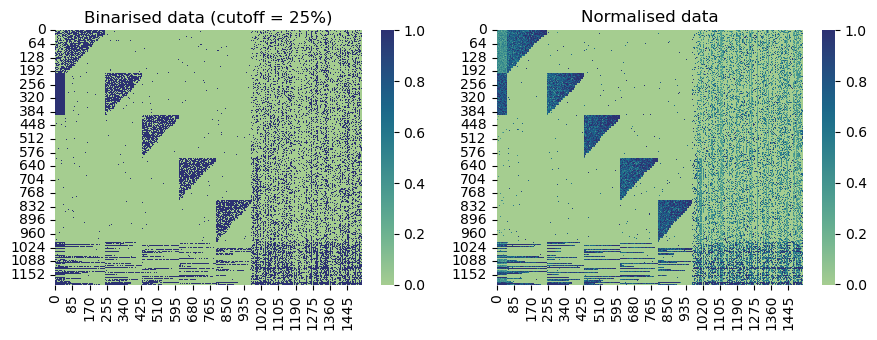

In [ ]:
# Visual check to see whether the binarisation is reasonable
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.heatmap(binarised_df, cmap="crest", ax=axes[0])
axes[0].set_title(f'Binarised data (cutoff = {25}%)')

sns.heatmap(norm_orig, cmap="crest", ax=axes[1])
axes[1].set_title('Normalised data')

plt.tight_layout()
plt.show()

Optional: inspect dataframe to make informed preprocessing decisions

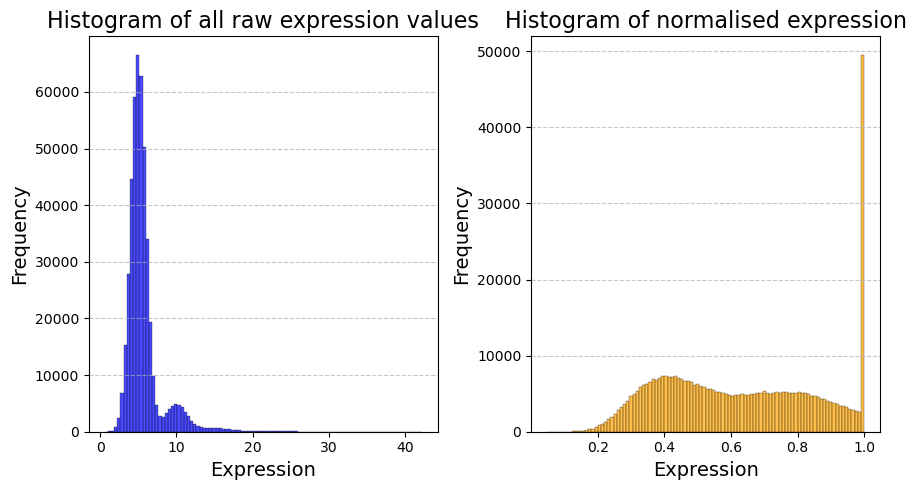

In [15]:
# We can also check the distribution of the nonzero data
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
sns.histplot(syndata[syndata > 0].values.flatten(), bins=100, color='blue', alpha=0.7, ax = axes[0])
axes[0].set_title('Histogram of all raw expression values', fontsize=16)
axes[0].set_xlabel('Expression', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.histplot(norm_orig[norm_orig > 0].values.flatten(), bins=100, color='orange', alpha=0.7, ax = axes[1])
axes[1].set_title('Histogram of normalised expression', fontsize=16)
axes[1].set_xlabel('Expression', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
# Ideally, one should use summary statistics...
print(syndata.describe().T)

       count      mean       std  min  25%       50%       75%        max
0     1200.0  3.610819  4.398713  0.0  0.0  0.000000  6.141918  23.505386
1     1200.0  3.526876  4.445757  0.0  0.0  0.000000  6.248662  22.405034
2     1200.0  3.529193  4.340124  0.0  0.0  0.000000  6.222331  20.442517
3     1200.0  3.503946  4.361863  0.0  0.0  0.000000  6.170080  23.563370
4     1200.0  3.556708  4.432569  0.0  0.0  0.000000  6.184415  22.408242
...      ...       ...       ...  ...  ...       ...       ...        ...
1514  1200.0  1.360121  2.487276  0.0  0.0  0.000000  3.069133  16.396568
1515  1200.0  2.800925  3.392783  0.0  0.0  0.000000  5.191245  26.834075
1516  1200.0  2.061306  2.954519  0.0  0.0  0.000000  4.632070  16.811868
1517  1200.0  3.244695  3.595542  0.0  0.0  3.723333  5.324426  27.107221
1518  1200.0  2.017833  2.880758  0.0  0.0  0.000000  4.592661  16.383815

[1519 rows x 8 columns]


In [ ]:
# ... or use metrics to inspect the nonzero distributions


#### Carry out significance testing to assess which pairwise comparisons are worth making

In [ ]:
#### Significance testing: the chi-squared test


In [ ]:
#### Omega (Ω), the correlation metric, formerly Entropy Sort Score (ESS)

# The individual function to calculate the Omega score for a given feature
def bIFW_correlation(feature_ind, sign_comp, normalised_matrix, extra_vectors = False, zero_info = True, extra_info = False):
    import numpy as np
    import scipy
    # get the list of significant features
    sign_list = [feat[1] for feat in sign_comp if feat[0] == feature_ind][0]
    MI_vector = []
    S_q_vector = []
    S_m_vector = []
    f1 = np.array(normalised_matrix.iloc[:,feature_ind])
    
    for i in sign_list:
        #define feature 2
        f2 = np.array(normalised_matrix.iloc[:,i])
        n00 = 0
        n01 = 0
        n10 = 0
        n11 = 0
        
        if len(f1) != len(f2):
            print("Fixed feature and features from matrix must be of the same length (same n of cells).")
        else:
            c = len(f1)
            for (cell1, cell2) in zip(f1, f2):
                if cell1 == cell2:
                    if cell1 == 0:
                        n00 += 1
                    elif cell1 == 1:
                        n11 += 1
                        
                elif cell1 == 0:
                    if cell2 == 1:
                        n01 += 1
                        
                elif cell1 == 1:
                    if cell2 == 0:
                        n10 += 1
                        
        # check discretization
        ns = np.array([n00, n01, n10, n11])
        n_str = ["n00", "n01", "n10", "n11"]
        nsum = np.sum(ns)
        if nsum != c:
            print("Sum of state counts do not add up.")
            MI = np.nan
            S_q = np.nan
            S_m = np.nan
            
        #calculate c's - need to have at least one of each
        else:
            #wrt to f1
            c_m0 = n00 + n01
            c_m1 = n10 + n11
            #wrt to f2
            c_q0 = n00 + n10
            c_q1 = n01 + n11
            
            cs_MI = np.array([[c_m0, c_q0], [c_m0, c_q1],
                              [c_m1, c_q0], [c_m1, c_q1]])
            cs_S = np.array([[c_m0, c_m1],
                             [c_q0, c_q1]])
            
            MI_terms = []
            zeroterms = []
            for ind, n in enumerate(ns):
                if n != 0 & np.all(cs_MI[ind]) == False: #if n and both cs are nonzero, calculate
                    MI_term = (n/c * np.log2(c * n / (cs_MI[ind][0] * cs_MI[ind][1])))
                    MI_terms.append(MI_term)
                    
                else:
                    zeroterms.append(n_str[ind])
            MI = np.sum(MI_terms)
            
            # entropies separately
            S_m_terms = []
            S_q_terms = []
            
            for ind in range(len(cs_S)):
                S_m_terms.append(cs_S[0][ind]/c * np.log2(cs_S[0][ind]/c))
                S_q_terms.append(cs_S[1][ind]/c * np.log2(cs_S[1][ind]/c))
                
            S_m = np.sum(S_m_terms) * (-1)
            S_q = np.sum(S_q_terms) * (-1)

            if extra_info == True:     
                exclude = str()
                for t in zeroterms:
                    exclude += (t + ", ")
                print("Be aware that the counts " + exclude + "were 0. This affects the calculations.")
                
        MI_vector.append(MI)
        S_q_vector.append(S_q)
        S_m_vector.append(S_m)
    
    max_entropy = [max(Sm, Sq) for Sm, Sq in zip(S_m_vector, S_q_vector)]
    
    #now calculate omega
    if len(MI_vector) != len(max_entropy):
        raise ValueError("All vectors (MI, x_max, S_q and S_m) must have the same length")    

    omega_vector = np.array(MI_vector) / np.array(max_entropy)
    if extra_vectors == True:
        return [omega_vector, MI_vector, max_entropy]            
    else:
        return [omega_vector]
    
    
# The parallelised function to calculate the Omega for all features
def parallel_bIFW_correlation(binarised_data, sign_matrix, Use_Cores=-1):
    global binarised_dataset
    binarised_dataset = binarised_data
    print(f"Data loaded. Shape: {binarised_dataset.shape}. Proceeding to obtain indices for efficient ESS calculation.\n")
    nonzero = np.nonzero(sign_matrix.to_numpy())
    sign_comp = []
    for f in np.unique(nonzero[0]):
        #print(f"Gene {f} has a significant interaction with genes {nonzero[1][nonzero[0] == f]}")
        l = nonzero[1][nonzero[0] == f]
        sign_comp.append([f,l])
        #print(f"Gene {f} has a significant interaction with {len(l)} genes")
    Feature_Inds = [feat[0] for feat in sign_comp]
    print(f"Indices obtained. Proceeding with calculating ESSs in parallel.\n")
    
    ## Identify number of cores to use.
    Cores_Available = multiprocess.cpu_count()
    print("Cores Available: " + str(Cores_Available))
    if Use_Cores == -1:
        Use_Cores = Cores_Available - 1 # -1 Is an arbitrary buffer of idle cores that I set.
        if Use_Cores < 1:
            Use_Cores = 1
    print("Cores Used: " + str(Use_Cores))
    ## Perform calculations
    with np.errstate(divide='ignore',invalid='ignore'):
        allscores = p_map(partial(bIFW_correlation, sign_comp=sign_comp, normalised_matrix=binarised_dataset), Feature_Inds, num_cpus=Use_Cores)
    print(f"Calculations complete. Proceeding with matrix reconstruction.\n")
    omega = [row[0] for row in allscores]
    
    # Use allscores to build square matrix
    n = binarised_dataset.shape[1]
    indices = (nonzero[0], nonzero[1])
    values = [value for sublist in omega for value in sublist]
    # Initialize a zero matrix
    matrix = np.zeros((n, n), dtype=float)
    for row, col, value in zip(indices[0], indices[1], values):
        #print(f"Placing value {value} at position ({row}, {col})")  # Debug print
        matrix[row, col] = value
    
    print("Matrix construction complete. Saving to dataframe.")
    m = pd.DataFrame(matrix)
    return allscores, m